# Deep Neural Network for Credit Card Fraud-Detection - Application

The dataset used was downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud.
It contained transactions done in September 2013. It contains only numeric input variables as a 
result of PCA transformation due to confidentiality issues.

1. Importing all the packages required for the project.

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

np.random.seed(1)

2. Reading in the dataset

In [127]:
credit_data = pd.read_csv(r'/content/creditcard.csv')
print(credit_data.shape)
credit_data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


3. Creating train-test split of 75-25

In [128]:
from sklearn.model_selection import train_test_split

X = credit_data.iloc[:, 1:30]
Y = credit_data['Class']

print('X : ', X.head())
print('Y : ', Y.head())

X :           V1        V2        V3        V4  ...       V26       V27       V28  Amount
0 -1.359807 -0.072781  2.536347  1.378155  ... -0.189115  0.133558 -0.021053  149.62
1  1.191857  0.266151  0.166480  0.448154  ...  0.125895 -0.008983  0.014724    2.69
2 -1.358354 -1.340163  1.773209  0.379780  ... -0.139097 -0.055353 -0.059752  378.66
3 -0.966272 -0.185226  1.792993 -0.863291  ... -0.221929  0.062723  0.061458  123.50
4 -1.158233  0.877737  1.548718  0.403034  ...  0.502292  0.219422  0.215153   69.99

[5 rows x 29 columns]
Y :  0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64


In [129]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1234)
print('Shape of X_train : ', X_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of Y_train : ', Y_train.shape)
print('Shape of Y_test : ', Y_test.shape)

Shape of X_train :  (213605, 29)
Shape of X_test :  (71202, 29)
Shape of Y_train :  (213605,)
Shape of Y_test :  (71202,)


4. Sampling to handle imbalanced target label - under, over and SMOTE

In [130]:
#Under-sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_under_sampled, y_under_sampled = rus.fit_resample(X_train, Y_train)

#Over-sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_over_sampled, y_over_sampled = ros.fit_resample(X_train, Y_train)

#SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_sample(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [131]:
#Check the new shape of each training sample

print('Shape of under-sampled train dataset : ', X_under_sampled.shape)
print('Shape of over-sampled train dataset : ', X_over_sampled.shape)
print('Shape of SMOTE train dataset : ', X_smote.shape)

Shape of under-sampled train dataset :  (748, 29)
Shape of over-sampled train dataset :  (426462, 29)
Shape of SMOTE train dataset :  (426462, 29)


The under-sampled dataset contains very few data points, adn hence will nt be used for modeling. The next step is to chosse between over-sampled and SMOTE dataset. We will run a DNN model on both and see which one performs better


5. Convert the training dataset (both predictors as well as target variable) to an N-dimensional array of size (29, 142144) for vectorized implementation of neural networks.

In [132]:
# Convert the training samples to ND-arrays for creating a DNN from scratch.
print('SMOTE dataset :')
features_smote = X_smote.T
print(features_smote.shape)

labels_smote = y_smote.reshape(-1,1).T
print(labels_smote.shape)


SMOTE dataset :
(29, 426462)
(1, 426462)


6. Defining sigmoid and RELU function for implementation in the later part


In [0]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
   
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) 
  
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
   
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

7. Initializing parameters - the linear forward part of the model


In [0]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)           

    for l in range(1, L):
       
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] =  np.zeros((layer_dims[l], 1))
       
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

8. Doing the forward propagation 


In [0]:
#This is the linear forward model
def linear_forward(A, W, b):

    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache


In [0]:
#This is the linear activation forward model
def linear_activation_forward(A_prev, W, b, activation):
   
    if activation == "sigmoid":
       
        Z, linear_cache  = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
       
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
       
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [0]:
#Defining a final forward model to implement the linear as well as activation functions
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  

    for l in range(1, L):
        A_prev = A 
      
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
   
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

9. Computing the cost function

In [0]:
def compute_cost(AL, Y):
   
    m = Y.shape[1]
    logprobs = np.multiply(np.log(AL),Y) +  np.multiply(np.log(1-AL), (1-Y))
    cost = -1/m*np.sum(logprobs)
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

10. The next step is to do backward propagation based on the output of cost function

In [0]:
#Linear backward model
def linear_backward(dZ, cache):
   
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m*np.dot(dZ, A_prev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


In [0]:
#Linear backward activation model
def linear_activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
       
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
      
    return dA_prev, dW, db

In [0]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
       
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)],  current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

11. Updating parameters - weight and bias for each layer, each unit

In [0]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]  
    return parameters

12. Implement the full L-layer model

```
# This is formatted as code
```



In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                        

    parameters = initialize_parameters_deep(layers_dims)
  
    for i in range(0, num_iterations):

       
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693152
Cost after iteration 100: 0.693152
Cost after iteration 200: 0.693152
Cost after iteration 300: 0.693151
Cost after iteration 400: 0.693151
Cost after iteration 500: 0.693151
Cost after iteration 600: 0.693150
Cost after iteration 700: 0.693150
Cost after iteration 800: 0.693150
Cost after iteration 900: 0.693149
Cost after iteration 1000: 0.693149
Cost after iteration 1100: 0.693149
Cost after iteration 1200: 0.693149
Cost after iteration 1300: 0.693149
Cost after iteration 1400: 0.693148
Cost after iteration 1500: 0.693148
Cost after iteration 1600: 0.693148
Cost after iteration 1700: 0.693148
Cost after iteration 1800: 0.693148
Cost after iteration 1900: 0.693148
Cost after iteration 2000: 0.693148
Cost after iteration 2100: 0.693148
Cost after iteration 2200: 0.693147
Cost after iteration 2300: 0.693147
Cost after iteration 2400: 0.693147
Cost after iteration 2500: 0.693147
Cost after iteration 2600: 0.693147
Cost after iteration 2700: 0.693147
Cost

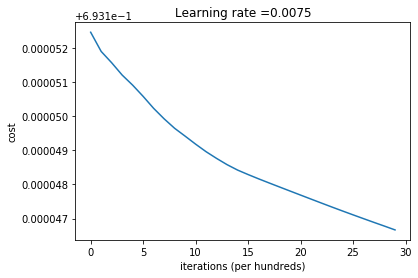

In [144]:
dimensions = [features_smote.shape[0], 24, 20, 5, labels_smote.shape[0]]
parameters = L_layer_model(features_smote, labels_smote, dimensions, num_iterations = 3000, print_cost = True)

In [0]:
def predict(parameters, X):
   
    A2, cache = L_model_forward(X, parameters)
    predictions = np.round(A2)
    return predictions

In [0]:
pred_train = predict(parameters, features)
pred_test = predict(parameters, np.asarray(X_test).T)

In [148]:
#Computing accuracy and sensitivity for the predicted validation set
actual_labels = np.asarray(Y_test).reshape(1,-1)
predicted_labels = pred_test

TP = np.squeeze(np.dot(actual_labels,predicted_labels.T))
TN = np.squeeze(np.dot(1-actual_labels,1-predicted_labels.T))
FN = np.squeeze(actual_labels[np.where(actual_labels == 0)].shape[0]  -   np.dot(1-actual_labels,1-predicted_labels.T))

accuracy  = (TP + TN)/(actual_labels.size)
sensitivity = np.round((TP*100/(TP+FN)),2)
print ('Accuracy: %d' % float((np.dot(actual_labels,predicted_labels.T) + np.dot(1-actual_labels,1-predicted_labels.T))/float(actual_labels.size)*100) + '%')
print(sensitivity)

Accuracy: 17%
0.17
